In [1]:
import pandas as pd

In [4]:
#importing the input file
df = pd.read_csv("amazon_reviews_sample.csv")
df.head()

,Unnamed: 0,score,review
0,0,1,Stuning even for the non-gamer: This sound tr...
1,1,1,The best soundtrack ever to anything.: I'm re...
2,2,1,Amazing!: This soundtrack is my favorite musi...
3,3,1,Excellent Soundtrack: I truly like this sound...
4,4,1,"Remember, Pull Your Jaw Off The Floor After H..."


In [5]:
#To print the dimension
df.shape

(10000, 3)

In [6]:
# To check for missing values
df.isna().sum()

Unnamed: 0    0
score         0
review        0
dtype: int64

In [8]:
# To check class imbalance
df['score'].value_counts()
#The classes are almost evenly balanced

0    5097
1    4903
Name: score, dtype: int64

In [7]:
#A Text before preprocessing
print(df['review'][0])

 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^



# Word Cloud

In [15]:
# define a function create_word_cloud to create a word cloud
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_word_cloud(score):
    word_cloud_collection =''
    if score==1:
        df_reviews = df[df['score']==1]['review']
    
    if score==0:
        df_reviews = df[df['score']==0]['review']
    
    for value in df_reviews.str.lower():
        tokens = word_tokenize(value)
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        for words in tokens:
            word_cloud_collection = word_cloud_collection + words + ' '
        
    wordcloud = WordCloud(max_words=150,background_color='white').generate(word_cloud_collection)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

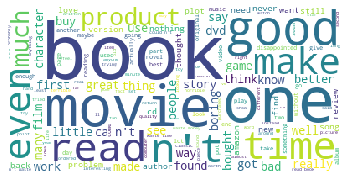

In [16]:
# word cloud for score=0
create_word_cloud(score = 0)

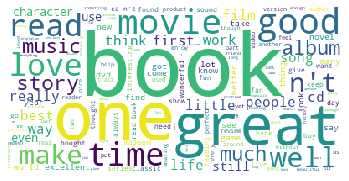

In [17]:
create_word_cloud(score=1)

# Text Preprocessing

In [19]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
ps = PorterStemmer()
corpus = []

for i in range(0, len(df)):
    review = re.sub('[^a-zA-Z]', ' ', df['review'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

print(corpus[0])

stune even non gamer sound track beauti paint seneri mind well would recomend even peopl hate vid game music play game chrono cross game ever play best music back away crude keyboard take fresher step grate guitar soul orchestra would impress anyon care listen


# Train and Test Split and Model Evaluation

In [65]:
# To split input data into train and test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(corpus, df['score'], random_state=1, test_size=0.3)


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

#To define a function for model Evaluation
def modelEvaluation(predictions):
    print("\nAccuracy on test set: {:4f}".format(accuracy_score(y_test,predictions)))
    print("\nClassification report : \n",classification_report(y_test,predictions))
    print("\nConfusion Matrix : \n", confusion_matrix(y_test,predictions))

# Train and predict a model using Pipeline and Voting Classifier

In [66]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Define the classifiers to pass to the voting classifier
SEED = 2
lr = LogisticRegression(max_iter=500, random_state=SEED)
mnb = MultinomialNB()
svc = LinearSVC(random_state=SEED)

In [67]:
classifiers = [('Logistic Regression', lr), ('MultinomialNB', mnb), ('LinearSVC', svc)]

In [68]:
# Create a pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import VotingClassifier
# Using Count Vectorizer
cv_pipeline = Pipeline([("count", CountVectorizer()),
                        ("vcf", VotingClassifier(estimators=classifiers))])

In [69]:
# Fitting training data to the pipeline
cv_pipeline.fit(X_train,y_train)
# Make prediction form the trained model
cv_prediction = cv_pipeline.predict(X_test)
# Perform model Evaluation
modelEvaluation(cv_prediction)


Accuracy on test set: 0.834667

Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.84      0.84      1509
           1       0.84      0.83      0.83      1491

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000


Confusion Matrix : 
 [[1271  238]
 [ 258 1233]]


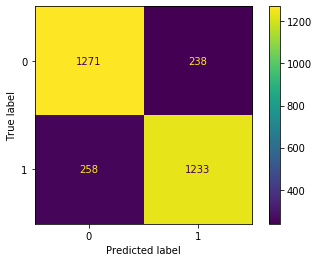

In [70]:
plot_confusion_matrix(cv_pipeline, X_test, y_test, values_format='d')

In [44]:
# Using Tfidf Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_pipeline = Pipeline([("tfidf", TfidfVectorizer()),
                            ("vcf", VotingClassifier(estimators=classifiers))])

In [45]:
# Fitting training to the tfidf pipeline
tfidf_pipeline.fit(X_train, y_train)
#Make predictions from the trained model
tfidf_prediction = tfidf_pipeline.predict(X_test)
# Perform Model Evaluation
modelEvaluation(tfidf_prediction)


Accuracy on test set: 0.848000

Classification report : 
               precision    recall  f1-score   support

           0       0.84      0.87      0.85      1509
           1       0.86      0.83      0.84      1491

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000


Confusion Matrix : 
 [[1312  197]
 [ 259 1232]]


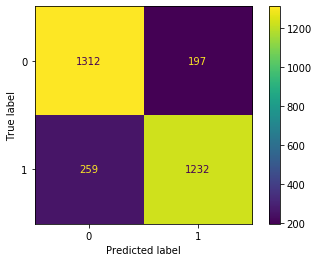

In [71]:
plot_confusion_matrix(tfidf_pipeline, X_test, y_test, values_format='d')

# Hyperparameter tuning

In [46]:
#  Since Tfidf performs slightly better than Count vectorizer we will tune tfidf pipeline to increase accuracy
from sklearn.model_selection import GridSearchCV

In [50]:
params ={"vcf__Logistic Regression__C":[1,10],
         "tfidf__max_features":[10000, 20000],
         "tfidf__ngram_range":[(1,1),(1,2),(1,3)],
         "vcf__MultinomialNB__alpha":[0.2,0.4,0.6,0.8,1.0]}

print(params)

{'vcf__Logistic Regression__C': [1, 10], 'tfidf__max_features': [10000, 20000], 'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)], 'vcf__MultinomialNB__alpha': [0.2, 0.4, 0.6, 0.8, 1.0]}


In [51]:
grid = GridSearchCV(estimator = tfidf_pipeline, param_grid=params, scoring='accuracy', n_jobs=1)
grid.fit(X_train,y_train)
print("The best parameter is", grid.best_params_)
grid_prediction = grid.predict(X_test)
modelEvaluation(grid_prediction)

The best parameter is {'tfidf__max_features': 20000, 'tfidf__ngram_range': (1, 3), 'vcf__Logistic Regression__C': 1, 'vcf__MultinomialNB__alpha': 1.0}

Accuracy on test set: 0.863333

Classification report : 
               precision    recall  f1-score   support

           0       0.86      0.87      0.87      1509
           1       0.87      0.85      0.86      1491

    accuracy                           0.86      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.86      0.86      0.86      3000


Confusion Matrix : 
 [[1319  190]
 [ 220 1271]]


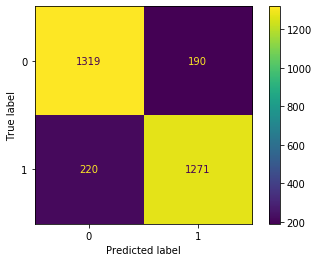

In [64]:
plot_confusion_matrix(grid, X_test, y_test, values_format='d')